## Model 1

This model assumes that the ecological suitability distribution ($Y$) and sampling effort $X$ process are independent. The structure of the model is visualised as a directed acyclic graph (DAG) in the following figure. For a detail explanation of the model refer to the supplementary materials of the manuscript.

Load necessary libraries and preprocess data

<img src="m1.png" alt="fig model I"  width="400px">

In [11]:
setwd('/main/app/external_plugins/biospytial_rwrapper/CAR-1SDM/')
source('R/preprocess_data.R')

Load the function for model I

In [14]:
source("joint.binomial.bymCARModel1.R")

A brief data exploration shows the number of relative absences and presences (npresence_0,npresece_1) in the "presences" process $Y$, the in the sampling process $X$  (i.e. nsample_0 and nsample_1, respectively). Missed data (no observations) are shown as n_miss_presence and n_miss_sample. for $Y$ and $X$ respectively.


In [4]:
ntot = length(DataFrame$sample)
npresence_1 = length(na.omit(DataFrame$species[DataFrame$species == 1])) / ntot*100
nsample_1 = length(na.omit(DataFrame$sample[DataFrame$sample == 1]))/ntot*100
npresence_0 = length(na.omit(DataFrame$species[DataFrame$species == 0]))/ntot*100
nsample_0 = length(na.omit(DataFrame$sample[DataFrame$sample == 0]))/ntot*100
n_miss_presence = sum(is.na(DataFrame$species))/ntot*100
n_miss_sample = sum(is.na(DataFrame$sample))/ntot*100
cbind(npresence_0,npresence_1,nsample_0,nsample_1,n_miss_presence,n_miss_sample)
#+end_src


npresence_0,npresence_1,nsample_0,nsample_1,n_miss_presence,n_miss_sample
63.02956,8.399015,10.59113,71.42857,28.57143,17.9803


## Prepraring the model for crossvalidation
1. Load libraries for calculating the receiving operator characteristic curve (ROC)


In [15]:
## Make ROC curve
library(pROC)
library('caret')
#trains = createFolds(y = DataFrame$species, k=7, returnTrain = TRUE)


2. Create partitions for cross validation using the K-fold method (k=7) and prepare the dataframe to receive results.


In [16]:

nonas = which(! is.na(DataFrame$species) )
Y_withoutNA = DataFrame$species[nonas]
validate = createFolds(y = Y_withoutNA, k=7, returnTrain = FALSE)


DataFrame$presences <- DataFrame$species

l <- list()
i = 1
DataFrame$predicted_values_CV <- NA
DataFrame$predicted_valuesBernoulli <- NA


3. Define the formulas for the presence (environmental) process $Y$ and the sampling effort $X$

In [17]:
formula_sample =  sample ~ Disttoroadm + Populationm
formula_presence = species ~ Elevationm + Precipitationm

4. Cross validation
    - Define parameters for sampling the posterior distribution using MCMC

In [18]:
n.sample = 20000                                                                                 
burnin=15000                                                                                      
postburnin = burnin + 1000                                                                         

n.sample = 200                                                                                 
burnin=150                                                                                      
postburnin = burnin + 10                                                                         


for (fold in validate) {

    observed.presences <- DataFrame$species[fold]
    ## Substitue by NA
    DataFrame$species[fold] <- NA
    results  <- joint.binomial.bymCARModel1(formula_S = formula_sample,
                                        formula_P = formula_presence,
                                        n.sample=n.sample,
                                        data = DataFrame,
                                        burnin=burnin,
                                        postburnin=postburnin,
                                        thin=thin,
                                        verbose=TRUE)

    DataFrame$species <- DataFrame$presences
    ## Return original values
    DataFrame$predicted_values_CV[fold] <- results$fitted.values[fold]
    predicted.probability = results$fitted.values[fold]

    ## Generate Bernoulli sample [ Only for the fold data set]
    print("Generating bernoulli sampling...")

    post.joint = data.frame(results$samples$fitted.joint[fold])

    ptot <- post.joint %>% mutate_all(function(p) rbernoulli(1,p))

    sumpt <- colSums(ptot)

    nsamples = dim(ptot)[1]


    ProbPS <- sumpt / nsamples

    DataFrame$predicted_valuesBernoulli[fold] <- ProbPS

    i = i + 1
}


Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  1.6 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |======================================================================| 100%
Summarising results.
Finished in  1.6 seconds.
Sampling from the joint model 200 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
[1] "Compiling summary for S process"
[1] "Compiling summary for the P process"
[1] "Generating bernoulli sampling..."
Setting up the model.
Performing burnin period for Sample Effort Model 
  |======================================================================| 100%
Summarising results.
Finished in  1.6 seconds.
Setting up the model.
Performing burnin period for Presence model 
  |=========================================================

## Calculate and plot the ROC curve

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”


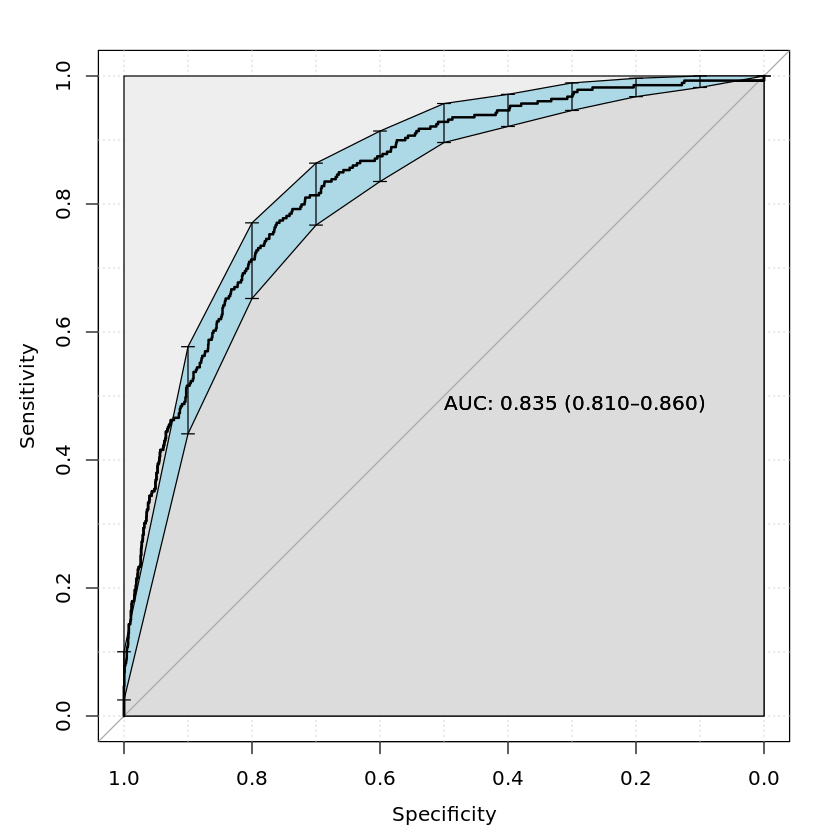

In [7]:
pROC_obj <- roc(DataFrame$presences,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE)
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")